In [1]:
import json
ds_train = json.load(open("training.json"))
ds_test = json.load(open("testing.json"))
imgs = ds_train["images"] + ds_test["images"]

# Classes for split

In [2]:
from tabulate import tabulate

pos_train = len([img for img in ds_train["images"] if img["is_candidate_location"]])
pos_test = len([img for img in ds_test["images"] if img["is_candidate_location"]])
neg_train = len([img for img in ds_train["images"] if not img["is_candidate_location"]])
neg_test = len([img for img in ds_test["images"] if not img["is_candidate_location"]])
print(tabulate([["", "Train", "Test", "Total"],
                ["Positives",
                 "{}({:.2f})".format(pos_train, pos_train * 100 /(pos_train+pos_test)),
                 "{}({:.2f})".format(pos_test, pos_test * 100 /(pos_train+pos_test)),
                 pos_train+pos_test],
                ["Negatives", 
                 "{}({:.2f})".format(neg_train, neg_train * 100 /(neg_train+neg_test)), 
                 "{}({:.2f})".format(neg_test, neg_test * 100 /(neg_train+neg_test)),
                 neg_train+neg_test]]))

---------  -----------  -----------  -----
           Train        Test         Total
Positives  3032(77.72)  869(22.28)   3901
Negatives  6064(77.72)  1738(22.28)  7802
---------  -----------  -----------  -----


In [3]:

fine_train = len([img for img in ds_train["images"] if img["valid_fine_grain"]])

fine_test = len([img for img in ds_test["images"] if  img["valid_fine_grain"]])

print(tabulate([["", "Train", "Test", "Total"],
                ["With fine grain labels",
                 "{}({:.2f})".format(fine_train, fine_train * 100 /(fine_train+fine_test)),
                 "{}({:.2f})".format(fine_test, fine_test * 100 /(fine_train+fine_test)),
                 fine_test+fine_train]]))

----------------------  ----------  ----------  -----
                        Train       Test        Total
With fine grain labels  882(84.24)  165(15.76)  1047
----------------------  ----------  ----------  -----


# Labels per split

In [4]:
from collections import Counter

cat_training = []
for img in ds_train["images"]:
    cat_training.extend(img["categories"])
cat_training = Counter(cat_training)

cat_testing = []
for img in ds_test["images"]:
    cat_testing.extend(img["categories"])
cat_testing = Counter(cat_testing)

table = [["Label", "Images", "Train imgs", "Train(%)", "Test imgs", "Test(%)"]]
tot_train, tot_test = 0,0
for cat in ds_test["categories"]:
    train, test = cat_training[cat["id"]],cat_testing[cat["id"]]
    tot_train += train
    tot_test += test
    tot = train+test
    table.append([cat["name"], tot, train, "{:.2f}".format(train*100/tot), test, "{:.2f}".format(test*100/tot)])
tot = tot_train+tot_test
table.append(["TOTAL", tot, tot_train, "{:.2f}".format(tot_train*100/tot), test, "{:.2f}".format(tot_test*100/tot)])
    
print(tabulate(table))


--------------------------------------------  ------  ----------  --------  ---------  -------
Label                                         Images  Train imgs  Train(%)  Test imgs  Test(%)
Rubble/excavated earth and rocks              446     381         85.43     65         14.57
Bulky items                                   396     352         88.89     44         11.11
Fire Wood                                     229     192         83.84     37         16.16
Scrap                                         258     231         89.53     27         10.47
Plastic                                       178     154         86.52     24         13.48
Vehicles                                      78      53          67.95     25         32.05
Tires                                         55      42          76.36     13         23.64
Domestic appliances                           26      21          80.77     5          19.23
Paper                                         37      32          

# Segmentations per label

In [5]:
anns = [ann["category_id"] for ann in ds_test["annotations"]]
print("Images with annotations", len(set([ann["image_id"] for ann in ds_test["annotations"]])))
cat_anns_testing = Counter(anns)
counter = 0
table_anns = []
for cat in ds_test["categories"]:
    table_anns.append([cat["name"],cat_anns_testing[cat["id"]]])
    counter += cat_anns_testing[cat["id"]]
table_anns.append(["Total",counter])
print(tabulate(table_anns))

Images with annotations 166
--------------------------------------------  ---
Rubble/excavated earth and rocks              126
Bulky items                                    69
Fire Wood                                      62
Scrap                                           0
Plastic                                         0
Vehicles                                       69
Tires                                          36
Domestic appliances                             0
Paper                                           0
Sludge-Zootechnical waste-Manure                0
Foundry waste                                   0
Stone/marble processing waste                   0
Asphalt milling                                 0
Corrugated sheets (presumed asbestos-cement)    0
Glass                                           0
Heaps not delimited                           171
Full container                                185
Big bags                                       60
Full pallets          

# Positives properties

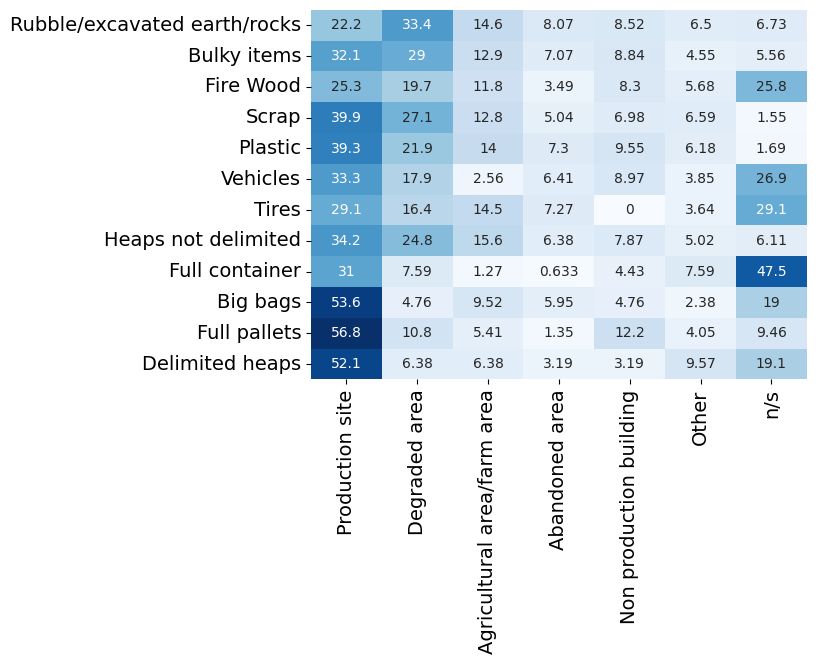

In [6]:
import matplotlib.pyplot as plt     
import pandas as pd
import seaborn as sns
from collections import Counter

names = ['Rubble/excavated earth and rocks', 'Bulky items', 'Fire Wood', 'Scrap', 'Plastic', 'Vehicles', 'Tires', 'Heaps not delimited', 'Full container', 'Big bags', 'Full pallets', 'Delimited heaps (by barriers/walls/etc)' ]
names_display = ['Rubble/excavated earth/rocks', 'Bulky items', 'Fire Wood', 'Scrap', 'Plastic', 'Vehicles', 'Tires', 'Heaps not delimited', 'Full container', 'Big bags', 'Full pallets', 'Delimited heaps' ]
pname = "site_type"
propert = ['Production site','Degraded area', 'Agricultural area/farm area', 'Abandoned area', 'Non production building', 'Other','n/s']

ll = []
for img in imgs:
    if not "site_type" in img.keys():
        img["site_type"] = "n/s"
    if img["site_type"] == "Natural area" or img["site_type"] =='Public area' or img["site_type"] == 'Ecological pitch':
        img["site_type"] = "Other"
    
df = pd.DataFrame(imgs)
for sm in ds_test["categories"]:
    if not sm["name"] in names:
        continue
    lt = []
    for p in propert:
        a = df[(df['categories'].map(lambda x: sm["id"] in x))] # Filter on images annotated with the given sm category
        b = a.loc[df[pname] == p] # Filter by property value (use .loc to avoid warnings)
        lt.append(len(b))
        
    t = sum(lt)
    lt = list(map((lambda x: x/sum(lt)*100), lt))
    ll.append(lt)

ax = plt.subplot()
sns.heatmap(ll, annot=True, fmt='.3g', ax=ax, cbar=False, cmap="Blues")  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.yaxis.set_ticklabels(names_display, fontsize = 14)
ax.xaxis.set_ticklabels(propert, fontsize = 14)

plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.show();

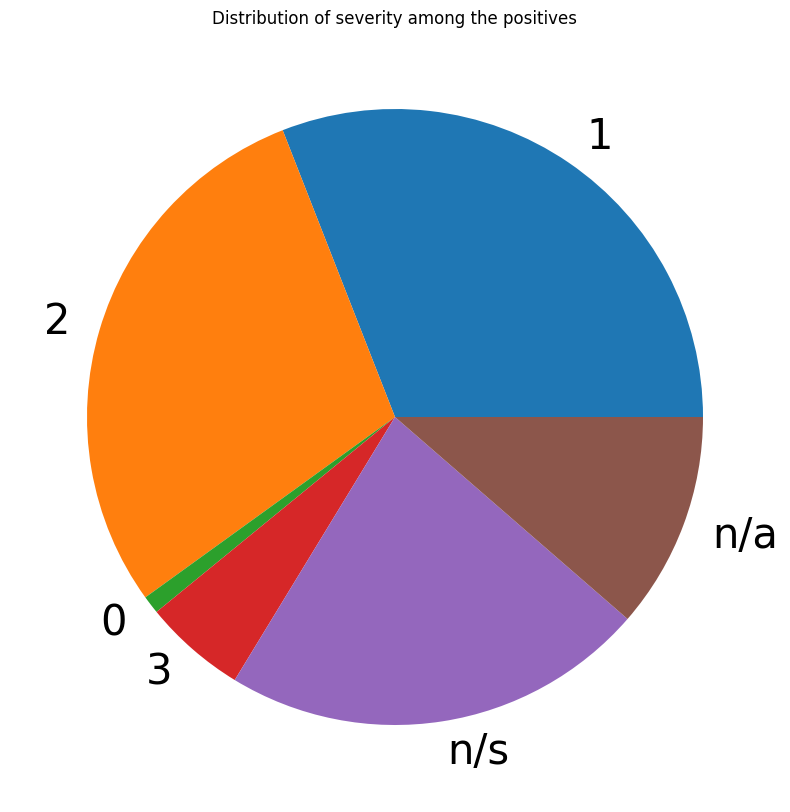

In [7]:
sev_count = Counter([img["severity"] for img in imgs if img["is_candidate_location"]])
plt.figure(figsize=(10,10))
plt.pie(sev_count.values(), labels = sev_count.keys(), #autopct='%1.1f%%',
        textprops={'fontsize': 30})

plt.title("Distribution of severity among the positives")
plt.show();

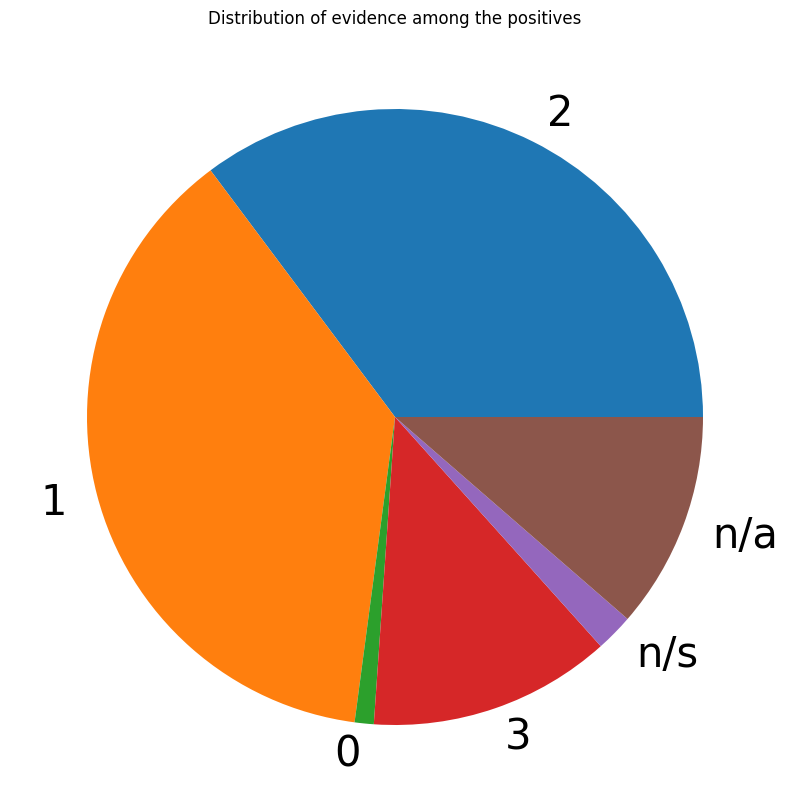

In [8]:
ev_count = Counter([img["evidence"] for img in imgs if img["is_candidate_location"]])
plt.figure(figsize=(10,10))
plt.pie(ev_count.values(), labels = ev_count.keys(), #autopct='%1.1f%%',
        textprops={'fontsize': 30})

plt.title("Distribution of evidence among the positives")
plt.show();